# Training a variational quantum circuit with Pennylane

In this notebook, we will learn how to build and train a variatioal quantum circuit (VQA) to generate a predefined 4 qubit target state from a 4 qubit random state of our choice.  

In [2]:
import matplotlib.pyplot as plt

from pennylane import numpy as np
import pennylane as qml
import torch
from torch.autograd import Variable

## Introduction

Given the following predefined 4 qubit states: $\lvert 0011 \rangle$, $\lvert 0101 \rangle$, $\lvert 1010 \rangle$, $\lvert 1100 \rangle$. Our goal is to create a quantum circuit that can do the following mapping:

- Initial random state 1, returns $\lvert 0011 \rangle$.
- Initial random state 2, returns $\lvert 0101 \rangle$.
- Initial random state 3, returns $\lvert 1010 \rangle$.
- Initial random state 4, returns $\lvert 1100 \rangle$.

However, for the sake of simplicity in the first section, I am going to also predefine the initial random state. In the second section, we will see how the code in the first section can be extended to solve the initial statement.

$$\lvert 0001 \rangle ⟶  \lvert 0011 \rangle $$
$$\lvert 0010 \rangle ⟶  \lvert 0101 \rangle $$
$$\lvert 0100 \rangle ⟶  \lvert 1010 \rangle $$
$$\lvert 1000 \rangle ⟶  \lvert 1100 \rangle $$


In [3]:
initial_states = [
    np.array([0, 0, 0, 1]),
    np.array([0, 0, 1, 0]),
    np.array([0, 1, 0, 0]),
    np.array([1, 0, 0, 0])
]


target_states = [
    np.array([0, 0, 1, 1]),
    np.array([0, 1, 0, 1]),
    np.array([1, 0, 1, 0]),
    np.array([1, 1, 0, 0])
]

## Defining a circuit

The most difficult part defining a circuit is to choose a good ansatz. Since I don't have a clue of what will work best I will implement a general circuit parametrized. Using 2 rotational qubit gates (Rx and Ry) I can generate all possible state in the Bloch Sphere and to generate entanglement I will implement several CNOT gate to entangle all the qubits. 

I will repeat this layer (rotation gates + CNOT gates) 2 times. The number of layers is an hyperparameter that we may need to tune later.

**Important:**  We need to set the parameters for the rotational gates, since I want to generate all possible angles, I will generate random numbers from $0$ to $\pi$.

<font color=red>'NOT COMPLETLY SURE'</font>  
In the [tutorial](https://pennylane.ai/qml/demos/tutorial_state_preparation.html) generates random numbers from 0 to pi. This is enough to generat all possible states in the bloch sphere.

In [4]:
n_qubits = 4
n_layers = 2
n_rotations = 2

# randomly initialize parameters from a normal distribution
params = np.random.normal(0, np.pi, (n_qubits, n_layers, n_rotations))
params = Variable(torch.tensor(params), requires_grad=True)

def circuit_layer(n_qubits, params, layer_lvl):
    for i in range(n_qubits):
        qml.RX(params[i, layer_lvl, 0], wires=i)
        qml.RY(params[i, layer_lvl, 1], wires=i)

    # Entangling all qubits
    qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="all_to_all")

Now, we will define our circuit in 3 steps: 


**1. Initialize in the right state.**  
All circuit start with all qubits in the zero state, $\lvert 0\rangle$. Using ```qml.BasisState``` our circuit will start with the state of our choice: $\lvert 0001 \rangle$ or $\lvert 0010 \rangle$, etc.

**2. Implement the layer.**  
Using a simple for loop we can add as many layers as we want.

**3. Measurement.**    
In this last step, we will measure the **fidelity** between the **output state** and **target state**. The fidelity is a value between 0 (orthogonal) or 1 (equal) that measure if the closeness between two states, in other words it measures if both states are similar or not. 

In [5]:
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def circuit(params, initial_state, fidelity_op, n_layers):
    n_qubits = len(initial_state)
    qml.BasisState(initial_state, wires=range(n_qubits))
    
    for layer_lvl in range(n_layers):
        circuit_layer(n_qubits, params, layer_lvl)

    return qml.expval(qml.Hermitian(fidelity_op, wires=range(n_qubits)))

## Define a cost function

The cost function helps the circuit to find the target state. In this case a good cost function will be the fidelity, so we can simply define our cost funtion as:

$$ C(\theta) = \sum \big( 1-\langle \psi_o(\theta) \lvert \psi_t \rangle \big) ^2 $$

where $\theta$ are the variational parameters that the circuit needs to tune, $\psi_o$ is the output state, $\psi_t$ is one of the target states that we have define in the begining and $\langle \psi_o(\theta) \lvert \psi_t \rangle$ is how the fidelity is computed.


### Explaining fidelity_op (Extra)

_I have written this subsection in case someone needs to understand how to implement the fidelity operator._

Suppose I have the inital state $\lvert 00 \rangle$ and our target is $\lvert 01 \rangle$. If our quantum circuit doesn't works properly it can outputs states like:
- $\lvert 10 \rangle$
- $\lvert 11 \rangle$.  

But which state is closer to the target? In order to answer this question we can compute the fidelity operator of our target state ($\lvert 01 \rangle \langle 01 \rvert$).
$$ \lvert 01 \rangle \langle 01 \rvert = \begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}$$

And measure how close each state is:  
**State  $\lvert 10 \rangle$**:

$$ \begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}
\begin{pmatrix}
0  \\
0  \\
1  \\
0  \\
\end{pmatrix}
= 0$$ 

**State  $\lvert 11 \rangle$**:

$$ \begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}
\begin{pmatrix}
0  \\
0  \\
0  \\
1  \\
\end{pmatrix}
= 0$$ 

**IMPORTANT**

Even though state $\lvert 11 \rangle$ is closer to $\lvert 01 \rangle$ (there is only 1 qubit wrong), the fidelity interprets that both $\lvert 11 \rangle$ and $\lvert 10 \rangle$ are far away from $\lvert 01 \rangle$.

<font color=red>'ASK'</font>  
So perhaps, fidelity is not a good cost function for this case.

In [6]:
def tensor_product(matrices: list):
    if len(matrices)==2:
        return np.kron(matrices[0], matrices[1], requires_grad=False)
    return np.kron(matrices[0], tensor_product(matrices[1:]), requires_grad=False)


def density_matrix(state):
    """Computes the density matrix of a state. 
    Given the state |0001> it will compute |0001><0001|
    
    Args:
        state (np.array): array representing a quantum state vector
    
    Returns:
        density_matrix (np.array): array representing the density matrix
    
    """
    zero_state = np.array([1, 0], requires_grad=False)
    one_state = np.array([0, 1], requires_grad=False)
    matrices = [zero_state if qubit_state == 0 else one_state for qubit_state in state]
    vector = tensor_product(matrices)
    return np.outer(vector, np.conj(vector), requires_grad=False)


def cost(params, initial_states, target_states, n_layers):
    loss = 0
    fidelity_operators = [density_matrix(i) for i in target_states]
    for i in range(len(target_states)):

        fidelity = circuit(params, initial_states[i], fidelity_operators[i], n_layers)
        loss += (1 - fidelity) ** 2

    return loss / len(target_states)

To find the best parameters I use the code that you can find in this [tutorial](https://pennylane.ai/qml/demos/tutorial_state_preparation.html). We simply set a classical optimizer that find the best parameters to minimize the previous cost function.

In [7]:
# set up the optimizer
opt = torch.optim.Adam([params], lr=0.1)

# number of steps in the optimization routine
steps = 200

# the final stage of optimization isn't always the best, so we keep track of
# the best parameters along the way
best_cost = cost(params, initial_states, target_states, n_layers)
best_params = np.zeros((n_qubits, n_layers, n_rotations))

print("Cost after 0 steps is {:.4f}".format(best_cost))

# optimization begins
for n in range(steps):
    opt.zero_grad()
    loss = cost(params, initial_states, target_states, n_layers)
    loss.backward()
    opt.step()

    # keeps track of best parameters
    if loss < best_cost:
        best_cost = loss
        best_params = params

    # Keep track of progress every 10 steps
    if n % 10 == 9 or n == steps - 1:
        print("Cost after {} steps is {:.4f}".format(n + 1, loss))

Cost after 0 steps is 0.9009


/media/gllodra12/extended_linux/Projectes/Quantum_projects/qosf/qosf_2021_09/venv/lib/python3.8/site-packages/torch/autograd/__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:240.)
  Variable._execution_engine.run_backward(


Cost after 10 steps is 0.6261
Cost after 20 steps is 0.3889
Cost after 30 steps is 0.3980
Cost after 40 steps is 0.3778
Cost after 50 steps is 0.3779
Cost after 60 steps is 0.3753
Cost after 70 steps is 0.3753
Cost after 80 steps is 0.3751
Cost after 90 steps is 0.3750
Cost after 100 steps is 0.3750
Cost after 110 steps is 0.3750
Cost after 120 steps is 0.3750
Cost after 130 steps is 0.3750
Cost after 140 steps is 0.3750
Cost after 150 steps is 0.3750
Cost after 160 steps is 0.3750
Cost after 170 steps is 0.3750
Cost after 180 steps is 0.3750
Cost after 190 steps is 0.3750
Cost after 200 steps is 0.3750


This results don't look really promising, perhaps we will need to increase the number of layers.  

In [8]:
def check_results(best_params, initial_states, target_states, n_layers):
    fidelity_operators = [density_matrix(i) for i in target_states]
    
    for initial_state, fidelity_op in zip(initial_states, fidelity_operators):
        fidelity = circuit(best_params, initial_state, fidelity_op, n_layers)
        print("From the initial state {} we get an output with fidelity {:.4f}".format(initial_state, fidelity))

check_results(best_params, initial_states, target_states, n_layers=2)

From the initial state [0 0 0 1] we get an output with fidelity 0.0000
From the initial state [0 0 1 0] we get an output with fidelity 0.5000
From the initial state [0 1 0 0] we get an output with fidelity 0.5000
From the initial state [1 0 0 0] we get an output with fidelity 0.9996


## Conclusion 1st circuit

Our circuit is not able generate the target states. We only get a good result with the input $\lvert 1000 \rangle$ because its fidelity is close to 1, which means that the output state is really close to the target state, $\lvert 1100 \rangle$.

Let's see if increasing the number of layers our results will improve.

In [14]:
def train(initial_states, target_states, n_layers, verbose=True):
    n_qubits = initial_states[0].size

    # Total of rotations gates (Rx and Ry)
    n_rotations = 2
    
    # Setting intial parameters
    params = np.random.normal(0, np.pi, (n_qubits, n_layers, n_rotations))
    params = Variable(torch.tensor(params), requires_grad=True)
    
    # Computing the best parameters
    opt = torch.optim.Adam([params], lr=0.1)

    # number of steps in the optimization routine
    steps = 200

    # the final stage of optimization isn't always the best, so we keep track of the best parameters along the way
    best_cost = cost(params, initial_states, target_states, n_layers)
    best_params = np.zeros((n_qubits, n_layers, n_rotations))

    if verbose:
        print("Cost after 0 steps is {:.4f}".format(best_cost))

    # optimization begins
    for n in range(steps):
        opt.zero_grad()
        loss = cost(params, initial_states, target_states, n_layers)
        loss.backward()
        opt.step()

        # keeps track of best parameters
        if loss < best_cost:
            best_cost = loss
            best_params = params

        # Keep track of progress every 10 steps
        if n % 10 == 9 or n == steps - 1:
            if verbose:
                print("Cost after {} steps is {:.4f}".format(n + 1, loss))
    
    return best_params, loss

In [10]:
best_params_10, _ = train(initial_states, target_states, 10)

Cost after 0 steps is 0.8472
Cost after 10 steps is 0.0996
Cost after 20 steps is 0.0303
Cost after 30 steps is 0.0180
Cost after 40 steps is 0.0101
Cost after 50 steps is 0.0062
Cost after 60 steps is 0.0050
Cost after 70 steps is 0.0043
Cost after 80 steps is 0.0038
Cost after 90 steps is 0.0035
Cost after 100 steps is 0.0033
Cost after 110 steps is 0.0031
Cost after 120 steps is 0.0029
Cost after 130 steps is 0.0028
Cost after 140 steps is 0.0026
Cost after 150 steps is 0.0026
Cost after 160 steps is 0.0025
Cost after 170 steps is 0.0024
Cost after 180 steps is 0.0023
Cost after 190 steps is 0.0023
Cost after 200 steps is 0.0022


In [11]:
check_results(best_params_10, initial_states, target_states, n_layers=10)

From the initial state [0 0 0 1] we get an output with fidelity 0.9480
From the initial state [0 0 1 0] we get an output with fidelity 0.9599
From the initial state [0 1 0 0] we get an output with fidelity 0.9563
From the initial state [1 0 0 0] we get an output with fidelity 0.9488


## Conclusion 2nd circuit

Much better!

Using 10 layers our circuit is able to generate output states that are REALLY close to the target states. We could increase the number of layers on our system but the results wouldn't improve drastically.

<font color=red>'ASK'</font>  
Why I need to use CNOT gates if neither the initial state nor the output state has entanglement???

In [22]:
layers = range(2, 14)
loss_list = list()

for n_layers in layers:
    print("Computing layer=", n_layers)
    _, loss = train(initial_states, target_states, n_layers, verbose=False)
    loss_list.append(loss.data)

Computing layer= 2
Computing layer= 3
Computing layer= 4
Computing layer= 5
Computing layer= 6
Computing layer= 7
Computing layer= 8
Computing layer= 9
Computing layer= 10
Computing layer= 11
Computing layer= 12
Computing layer= 13


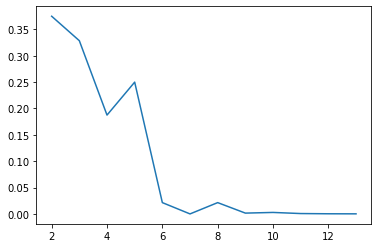

In [23]:
plt.plot(layers, loss_list)

## References

1. Training a circuit with PyTorch: https://pennylane.ai/qml/demos/tutorial_state_preparation.html
2. Cost function: https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier.html

### Extra 1: Random input state

In this section we will explore if the same circuit is able to get good results on random input states.  

To generate a random 4-qubit quantum state we will define a computational basis for 4-qubits and add random amplitudes ($c_0, c_1, c_2, c_3$).

$$ \psi = c_0\lvert 0 \rangle + c_1\lvert 1 \rangle + c_2\lvert 2 \rangle + c_3\lvert 3 \rangle $$

Recall that the quantum state must be normalize, so we need to impose the following constraint when we generate random values: 

$$|c_0|^2+|c_1|^2+|c_2|^2+|c_3|^2=1$$

In [24]:
# Vull que siguin complexos i random entre -1 i 1 i que entre -1 i 1 la distribucio sigui uniforme.